In [2]:
### import packages
%matplotlib widget

from essential_func import *
from analysis_data  import *
import ipywidgets as widgets

#### NN packages
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda
import sys, yaml

qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])

In [3]:
### kernel search class
%matplotlib widget

import pickle
from tqdm import tqdm
class KernelSearch(object):
    def __init__(self, df, kernal_size, seek_mf, area_minQ, area_maxQ, mf_min, mf_max, n_tissue_frms, qgrid, mf_Qindices=(1.55, 1.85), mse_minQ=1.0, mse_maxQ=1.25, n_sort=10):
        idx_start, idx_end = qgrid_to_indices(qgrid, mf_Qindices[0]) , qgrid_to_indices(qgrid, mf_Qindices[1])  

        columns   = ['in_frames', 'tissue_frames', 'bkg_frames', 'File_Loc', 'Width', 'Height']

        self.x      = None
        self.files  = []
        self.frames = []
        for df_idx in tqdm(range(len(df))):
            ### get dataframe rows data as a variable
            in_frames     = df.iloc[df_idx][columns[0]]
            in_frames     = [in_frames] if isinstance(in_frames, int) else in_frames   
            File_Loc      = df.iloc[df_idx][columns[3]]
            width         = df.iloc[df_idx][columns[4]]
            height        = df.iloc[df_idx][columns[5]]

            ### update each row "tissue_frames" column with tissue frames
            df.iloc[df_idx][columns[1]]   = [Snaking_frames_search(width, height).frame_idx_to_kernal_frames(kernal_size, frame) for frame in in_frames] # kernal tissue frames

            ### read the csv file for Intensity data
            df_file        = pd.read_csv(File_Loc,delimiter=',')

            ### get background intensity for each row
            bkg_frames    = df.iloc[df_idx][columns[2]]
            if isinstance(bkg_frames, dict):
                k, bkg_frames  = bkg_frames.items()
                df_bkg         = pd.read_csv(k,delimiter=',')
            elif isinstance(bkg_frames, list):
                df_bkg         = df_file
            elif bkg_frames is None:
                df_bkg         = df_file
                bkg_frames = []
            else:
                raise Exception('Did not find any background') 
            
            bkg_frames    = [bkg_frames] if isinstance(bkg_frames, int) else bkg_frames
            Iq_bkg = df_bkg.iloc[bkg_frames].to_numpy()
            Iq_bkg = np.round(np.mean(Iq_bkg, axis=0, keepdims=True),6)

            # else:   # if bkg_frames == None
            #     print(f'bkg file running from saved file for {File_Loc}')
            #     with open(mica_file, 'rb') as handle:
            #         data = pickle.load(handle)
            #     Iq_bkg = data['Iq_bkg']

            t_frames_ = []
            mf_pot_   = []
            area_pot_ = []
            sel_IqBSTF_ = []
            sel_IqBSTF_avg_ = []
            for idx, in_frame in enumerate(in_frames):

                ### potential frame, and tissue frame intensity - backgound intensity
                scaling_for = df_file.iloc[[in_frame]].to_numpy()  - Iq_bkg
                t_frames    = np.array(df.iloc[df_idx][columns[1]][idx])
                IqBS_tissue = df_file.iloc[ t_frames ].to_numpy()  - Iq_bkg

                ### declare temporary variables
                nTissue = len(IqBS_tissue)
                mf   = np.full(nTissue, np.nan)         # do not trust mf - nearby mf (two cluster same frame) is overwritten
                area = np.full(nTissue, np.nan)         # do not trust area - nearby area (two cluster same frame) is overwritten
                mse  = np.full(nTissue, np.nan)

                for i in range(nTissue):
                    scaling_by  = IqBS_tissue[[i],:]
                    mf[i]       = Iq_scaling(scaling_for[:,idx_start:idx_end], scaling_by[:,idx_start:idx_end], seek_mf, method = 'MSE')
                    area[i]     = Iq_area_sub(qgrid, scaling_for, scaling_by, mf[i], area_minQ, area_maxQ)
                    mse[i]      = Iq_mse_sub (qgrid, scaling_for, scaling_by, mf[i], mse_minQ,   mse_maxQ)

                tissue_area_sorted = np.argsort(area, axis= None, kind='stable')[::-1] # descending order
                tissue_mse_sorted  = np.argsort(mse, axis= None, kind='stable')[:n_sort] # ascending order
                tissue_idx_sorted  = tissue_area_sorted[np.isin(tissue_area_sorted,tissue_mse_sorted)]

                tissue_idx_pot    = []
                for pot_tissue in tissue_idx_sorted:
                    if mf[pot_tissue] < mf_max and mf[pot_tissue] > mf_min :
                        tissue_idx_pot.append(pot_tissue)

                    if len(tissue_idx_pot) == n_tissue_frms:
                        break            

                if len(tissue_idx_pot) == 0:
                        print('no tissue found for frame - ', in_frame, ' ; thus dropping this frame ->')
                        continue

                ### gettting tissue frames
                t_frames_.append([t_frames[pot_tissue_idx] for pot_tissue_idx in tissue_idx_pot])

                mf_pot__, area_pot__, sel_IqBSTF__, sel_IqBSTF_avg__ = [],[],[], []
                for pot_tissue_idx in tissue_idx_pot:
                    mf_pot__.append(    round(mf[pot_tissue_idx],4)   )
                    area_pot__.append(  round(area[pot_tissue_idx],10) )
                    sel_IqBSTF__.append(np.round(mf[pot_tissue_idx]*IqBS_tissue[pot_tissue_idx,:],6).tolist()) 

                mf_pot_.append(    mf_pot__    )
                area_pot_.append(  area_pot__  )
                sel_IqBSTF_.append(sel_IqBSTF__)
                sel_IqBSTF_avg_.append( np.mean(sel_IqBSTF__, axis=0).tolist() )  # (5, 690)

            sel_IqBSTF                          = sel_IqBSTF_              # (5, 3, 690)
            sel_IqBSTF_avg                      = np.vstack(sel_IqBSTF_avg_)          # (5, 690)
            df.at[df_idx, 'sel_tissue_frames']  = t_frames_                 
            df.at[df_idx, 'sel_tissue_mf']      = mf_pot_
            df.at[df_idx, 'sel_tissue_area']    = mf_pot_
            df.at[df_idx, 'sel_IqBSTF']         = sel_IqBSTF
            df.at[df_idx, 'sel_IqBSTF_avg']     = sel_IqBSTF_avg

            Iq                                  = np.round(df_file.iloc[in_frames].to_numpy(),6)
            df.at[df_idx, 'Iq']                 = Iq
            df.at[df_idx, 'Iq_bkg']             = Iq_bkg
            df.at[df_idx, 'Iq_BS']              = Iq - Iq_bkg
            df.at[df_idx, 'sel_IqBSTS']         = Iq - Iq_bkg - sel_IqBSTF_avg

            self.files  += [df.iloc[df_idx]['File_Loc']]*len(in_frames)
            self.frames += in_frames
            self.x      = np.concatenate((self.x, df.iloc[df_idx]['sel_IqBSTS']), axis=0) if self.x is not None else df.iloc[df_idx]['sel_IqBSTS']
        self.df     = df

    def __len__(self):
        return len(self.x)
    def tissue_sub_plots(self, index):
        plaque = obj.df['plaque-frame'].loc[index]
        plt.cla()
        plt.plot(obj.data.qgrid[obj.start:obj.end], obj.data.Iq[plaque][obj.start:obj.end]        ,  color= 'blue',  label = 'Iq' )
        plt.plot(obj.data.qgrid[obj.start:obj.end], obj.data.IqBS[plaque][obj.start:obj.end]      ,  color= 'red',   label = 'IqBS'  )
        plt.plot(obj.data.qgrid[obj.start:obj.end], obj.df['IqBSTF'].loc[index][obj.start:obj.end],  color= 'green',  label = 'IqBSTF')
        plt.plot(obj.data.qgrid[obj.start:obj.end], obj.df['IqBSTS'].loc[index][obj.start:obj.end],  color= 'orange', label = 'IqBSTS')
        plt.legend()
        plt.axhline(y=0, color='black', linewidth=1.0 ,linestyle='--')
        plt.xlabel('q')
        plt.ylabel('intensity')

        if save_fr_csv:
            df_index= pd.DataFrame({'qgrid':obj.data.qgrid[obj.start:obj.end], 'Iq':obj.data.Iq[plaque][obj.start:obj.end], 'IqBS':obj.data.IqBS[plaque][obj.start:obj.end], 'IqBSTF': obj.df['IqBSTF'].loc[index][obj.start:obj.end], 'IqBSTS': obj.df['IqBSTS'].loc[index][obj.start:obj.end]})
            df_index.to_csv(f'{sample_file}-{plaque}.csv')
        else:
            pass

        # if obj.tissue_frs_find_alg == 'one-fr-one-cluster' or obj.tissue_frs_find_alg == 'all-frs-one-cluster' :
        #     plt.title(f'plaque-fr-{plaque}, group-{obj.df["cluster-label"][index]}, index:{index}')
        # else:
        plt.title(f'plaque-fr-{plaque}')
        #plt.axis([None,None,None,0.12*10**6])

In [24]:
### specs
area_minQ = 1.325
area_maxQ = 1.395
mf_max = 3
mf_min = 0.5
seek_mf = [mf_min,mf_max,0.01]

mse_minQ=1.0
mse_maxQ=1.25
n_sort = 30
n_tissue_frms = 3
mf_Qindices= (1.55, 1.85)  # (1.55, 1.85)  (0.8, 1.15)
kernal_size = 9
mica_file = '/Users/bashit.a/Documents/Alzheimer/Codes/mica.pickle'

### create Dataframe
df_in = pd.DataFrame(columns=  ['in_frames', 'tissue_frames', 'bkg_frames', 'File_Loc', 'Width', 'Height', 'sel_tissue_frames', 'sel_tissue_mf', 'sel_tissue_area', 'sel_IqBSTF', 'sel_IqBSTF_avg', 'sel_IqBSTS', 'Iq', 'Iq_bkg', 'Iq_BS'])

### ------ Neuritic ----------- ###
df_in.at[0, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv'
df_in.at[0, 'Width']        = 61
df_in.at[0, 'Height']       = 62
df_in.at[0, 'in_frames']    = [2576, 2577, 2666, 2667, 2668, 2669, 2670, 2698, 2699, 2700, 2789, 2790, 2791, 2792]
df_in.at[0, 'bkg_frames']   = [26,27,73,74,121,178,179,180,181,207,263,300,301,308,423,460,461,514,515,520,521,533,541,542,565,576,577,639,653,654,655,687,688,689,744,745,769,775,776,777,824,935,936,937,938,947,948,955,956,982,983,984,1002,1003,1004,1005,1017,1022,1033,1049,1050,1051,1053,1069,1070,1071,1072,1085,1086,1110,1124,1125,1126,1142,1193,1194,1284,1316,1330,1331,1332,1353,1368,1369,1374,1414,1430,1438,1447,1448,1449,1450,1478,1479,1480,1503,1536,1545,1546,1547,1573,1574,1575,1596,1597,1624,1625,1626,1627,1665,1666,1667,1668,1697,1698,1709,1710,1749,1762,1763,1764,1769,1770,1771,1773,1774,1775,1794,1795,1796,1864,1865,1866,1915,1916,1935,1936,1974,1975,1976,1999,2000,2010,2011,2012,2013,2014,2030,2031,2032,2049,2050,2051,2052,2058,2096,2097,2098,2099,2106,2107,2108,2116,2117,2118,2160,2161,2162,2163,2164,2171,2172,2173,2227,2228,2230,2231,2232,2277,2281,2282,2283,2284,2340,2341,2342,2351,2352,2353,2359,2372,2373,2383,2384,2385,2395,2396,2397,2398,2403,2404,2405,2406,2413,2414,2456,2457,2466,2472,2473,2474,2475,2476,2477,2479,2480,2481,2482,2483,2484,2485,2494,2495,2517,2518,2519,2520,2521,2522,2523,2524,2525,2544,2545,2551,2552,2596,2600,2601,2602,2603,2604,2605,2606,2607,2622,2623,2624,2625,2639,2642,2643,2644,2645,2646,2650,2724,2725,2726,2727,2728,2729,2761,2762,2763,2764,2765,2766,2767,2768,2787,2788,2823,2830,2831,2844,2845,2846,2847,2848,2849,2850,2851,2883,2884,2885,2912,2913,2914,2973,3008,3016,3082,3083,3084,3243,3248,3255,3256,3332,3340,3341,3368,3369,3388,3407,3433,3434,3435,3445,3459,3460,3492,3493,3514,3515,3520,3547,3555,3557,3609,3629,3630,3650,3666,3667,3668,3710,3721,3722,3723,3724,3768,3773,3774]

# df_in.at[1, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv'
# df_in.at[1, 'Width']        = 62
# df_in.at[1, 'Height']       = 61
# df_in.at[1, 'in_frames']    = [3314, 3383, 3436, 3438, 3439, 3444, 3496, 3504, 3505, 3506, 3558, 3562, 3563, 3571, 3619, 3620, 3624, 3633, 3697, 3745, 3746]
# df_in.at[1, 'bkg_frames']   = [0,1,2,454,489,497,498,503,504,788,789,822,823,824,860,876,877,910,911,912,913,1175,1179,1180,1502,1598,1599,1600,1993,2098,2099,2100,2101,2113,2114,2225,2226,2227,2236,2237,2238,2239,2240,2346,2347,2348,2349,2350,2351,2361,2362,2363,2364,2365,2469,2470,2471,2472,2473,2487,2488,2489,2594,2674,2675,2782,2798,2799,2903,3003,3004,3005,3006,3070,3071,3072,3073,3382,3437]

# df_in.at[2, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi0_0_0_masked.h5_merged.csv'
# df_in.at[2, 'Width']        = 62
# df_in.at[2, 'Height']       = 122
# df_in.at[2, 'in_frames']    = flatten([[4149, 4158, 4159, 4160, 4161, 4266, 4267, 4268, 4269, 4270, 4271, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290],[7110, 7150, 7151, 7152, 7153, 7154, 7155, 7226, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7350, 7351, 7352, 7354, 7355, 7356, 7357, 7398, 7399, 7400, 7401, 7403, 7404, 7405, 7406, 7474, 7475, 7476, 7478, 7479, 7480, 7481, 7523, 7525, 7527]])
# df_in.at[2, 'bkg_frames']   = [347,348,349,2203,2204,2260,2327,2328,2383,2384,2385,2451,2452,2453,2506,2507,2577,2634,2635,2636,2637,2695,2696,2697,2698,2756,2757,2758,2823,2824,2825,2826,2827,2828,2829,2830,2873,2874,2875,2876,2877,2878,2879,2880,2881,2954,2955,2956,2957,4272,4273,4803,4804,4805,4806,4867,4868,4869,4870,4871,4924,4925,4926] #   None 

### ------ Diffuse Plaque ----------- ###
# df_in.at[0, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948 V1-roi0_0_0_masked.h5_merged.csv'
# df_in.at[0, 'Width']        = 62
# df_in.at[0, 'Height']       = 61
# df_in.at[0, 'in_frames']    = [1927, 1928, 1929, 1930, 2037, 2038, 2039, 2040, 2051, 2052, 2053, 2054, 2161, 2162, 2163, 2164, 2165, 2166, 2175, 2176, 2177, 2178, 2284, 2285, 2286, 2287, 2288, 2289, 2298, 2299, 2300, 2301, 2302, 2409, 2410, 2411, 2412, 2413, 2423, 2424, 2535, 2536, 2537, 2547, 2548]
# df_in.at[0, 'bkg_frames']   = [94,95,96,97,122,151,152,218,626,639,640,641,722,743,744,867,1054,1135,1136,1429,1430,1614,1615,1616,1714,1831,1832,1838,1870,1871,1872,1881,1882,1888,1889,1954,1961,1962,2356,2357,2519,2520,2563,2564,2645,2679,2742,2777,2806,2897,3129,3219,3220,3221,3227,3228,3303,3392,3427,3515,3516,3517,3551,3639,3674,3675,3676]

# df_in.at[1, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv'
# df_in.at[1, 'Width']        = 62
# df_in.at[1, 'Height']       = 61
# df_in.at[1, 'in_frames']    = [3462, 3712]
# df_in.at[1, 'bkg_frames']   = [0,1,2,454,489,497,498,503,504,788,789,822,823,824,860,876,877,910,911,912,913,1175,1179,1180,1502,1598,1599,1600,1993,2098,2099,2100,2101,2113,2114,2225,2226,2227,2236,2237,2238,2239,2240,2346,2347,2348,2349,2350,2351,2361,2362,2363,2364,2365,2469,2470,2471,2472,2473,2487,2488,2489,2594,2674,2675,2782,2798,2799,2903,3003,3004,3005,3006,3070,3071,3072,3073,3382,3437]

# ### ------ NFT ----------- ###
# df_in.at[0, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi0_0_0_masked_intp.h5_merged.csv'
# df_in.at[0, 'Width']        = 61
# df_in.at[0, 'Height']       = 61
# df_in.at[0, 'in_frames']    = flatten([[768, 816, 818, 890, 891, 892], [ 865, 965, 988, 989, 1083, 1087 ]])
# df_in.at[0, 'bkg_frames']   = [122,123,291,338,397,460,483,484,516,604,637,640,641,795,805,806,902,970,1084,1085,1109,1205,1206,1227,1233,1234,1248,1249,1250,1251,1310,1311,1312,1313,1327,1328,1355,1356,1357,1372,1373,1531,1571,1638,1639,1640,1656,1686,1712,1823,1824,1825,1826,1834,1835,1836,1837,1839,1868,1873,1945,1946,1947,1948,1956,1957,1964,1965,2063,2100,2136,2169,2170,2171,2216,2217,2220,2221,2222,2295,2296,2297,2311,2312,2313,2444,2445,2491,2510,2558,2701,2702,2730,3068,3116,3149,3150,3151,3153,3191,3192,3193,3194,3225,3226,3238,3239,3240,3298,3299,3409,3410,3411,3420,3421,3422,3699,3709]

# df_in.at[1, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv'
# df_in.at[1, 'Width']        = 61
# df_in.at[1, 'Height']       = 62
# df_in.at[1, 'in_frames']    = [849, 850, 858, 859, 970, 1092, 1213, 1214]
# df_in.at[1, 'bkg_frames']   = [26,27,73,74,121,178,179,180,181,207,263,300,301,308,423,460,461,514,515,520,521,533,541,542,565,576,577,639,653,654,655,687,688,689,744,745,769,775,776,777,824,935,936,937,938,947,948,955,956,982,983,984,1002,1003,1004,1005,1017,1022,1033,1049,1050,1051,1053,1069,1070,1071,1072,1085,1086,1110,1124,1125,1126,1142,1193,1194,1284,1316,1330,1331,1332,1353,1368,1369,1374,1414,1430,1438,1447,1448,1449,1450,1478,1479,1480,1503,1536,1545,1546,1547,1573,1574,1575,1596,1597,1624,1625,1626,1627,1665,1666,1667,1668,1697,1698,1709,1710,1749,1762,1763,1764,1769,1770,1771,1773,1774,1775,1794,1795,1796,1864,1865,1866,1915,1916,1935,1936,1974,1975,1976,1999,2000,2010,2011,2012,2013,2014,2030,2031,2032,2049,2050,2051,2052,2058,2096,2097,2098,2099,2106,2107,2108,2116,2117,2118,2160,2161,2162,2163,2164,2171,2172,2173,2227,2228,2230,2231,2232,2277,2281,2282,2283,2284,2340,2341,2342,2351,2352,2353,2359,2372,2373,2383,2384,2385,2395,2396,2397,2398,2403,2404,2405,2406,2413,2414,2456,2457,2466,2472,2473,2474,2475,2476,2477,2479,2480,2481,2482,2483,2484,2485,2494,2495,2517,2518,2519,2520,2521,2522,2523,2524,2525,2544,2545,2551,2552,2596,2600,2601,2602,2603,2604,2605,2606,2607,2622,2623,2624,2625,2639,2642,2643,2644,2645,2646,2650,2724,2725,2726,2727,2728,2729,2761,2762,2763,2764,2765,2766,2767,2768,2787,2788,2823,2830,2831,2844,2845,2846,2847,2848,2849,2850,2851,2883,2884,2885,2912,2913,2914,2973,3008,3016,3082,3083,3084,3243,3248,3255,3256,3332,3340,3341,3368,3369,3388,3407,3433,3434,3435,3445,3459,3460,3492,3493,3514,3515,3520,3547,3555,3557,3609,3629,3630,3650,3666,3667,3668,3710,3721,3722,3723,3724,3768,3773,3774]

# df_in.at[2, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv'
# df_in.at[2, 'Width']        = 62
# df_in.at[2, 'Height']       = 61
# df_in.at[2, 'in_frames']    = flatten([[1812, 1907, 1935, 1936, 1937, 2031, 2032, 2059, 2060, 2061, 2155, 2156], [ 2321, 2390], [1472, 1473, 1474, 1475, 1476, 1477, 1499, 1500, 1501]])
# df_in.at[2, 'bkg_frames']   = [0,1,2,454,489,497,498,503,504,788,789,822,823,824,860,876,877,910,911,912,913,1175,1179,1180,1502,1598,1599,1600,1993,2098,2099,2100,2101,2113,2114,2225,2226,2227,2236,2237,2238,2239,2240,2346,2347,2348,2349,2350,2351,2361,2362,2363,2364,2365,2469,2470,2471,2472,2473,2487,2488,2489,2594,2674,2675,2782,2798,2799,2903,3003,3004,3005,3006,3070,3071,3072,3073,3382,3437]

### ------ Tau ----------- ###
# df_in.at[0, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv'
# df_in.at[0, 'Width']        = 61
# df_in.at[0, 'Height']       = 62
# df_in.at[0, 'in_frames']    = [1499, 1553]
# df_in.at[0, 'bkg_frames']   = [26,27,73,74,121,178,179,180,181,207,263,300,301,308,423,460,461,514,515,520,521,533,541,542,565,576,577,639,653,654,655,687,688,689,744,745,769,775,776,777,824,935,936,937,938,947,948,955,956,982,983,984,1002,1003,1004,1005,1017,1022,1033,1049,1050,1051,1053,1069,1070,1071,1072,1085,1086,1110,1124,1125,1126,1142,1193,1194,1284,1316,1330,1331,1332,1353,1368,1369,1374,1414,1430,1438,1447,1448,1449,1450,1478,1479,1480,1503,1536,1545,1546,1547,1573,1574,1575,1596,1597,1624,1625,1626,1627,1665,1666,1667,1668,1697,1698,1709,1710,1749,1762,1763,1764,1769,1770,1771,1773,1774,1775,1794,1795,1796,1864,1865,1866,1915,1916,1935,1936,1974,1975,1976,1999,2000,2010,2011,2012,2013,2014,2030,2031,2032,2049,2050,2051,2052,2058,2096,2097,2098,2099,2106,2107,2108,2116,2117,2118,2160,2161,2162,2163,2164,2171,2172,2173,2227,2228,2230,2231,2232,2277,2281,2282,2283,2284,2340,2341,2342,2351,2352,2353,2359,2372,2373,2383,2384,2385,2395,2396,2397,2398,2403,2404,2405,2406,2413,2414,2456,2457,2466,2472,2473,2474,2475,2476,2477,2479,2480,2481,2482,2483,2484,2485,2494,2495,2517,2518,2519,2520,2521,2522,2523,2524,2525,2544,2545,2551,2552,2596,2600,2601,2602,2603,2604,2605,2606,2607,2622,2623,2624,2625,2639,2642,2643,2644,2645,2646,2650,2724,2725,2726,2727,2728,2729,2761,2762,2763,2764,2765,2766,2767,2768,2787,2788,2823,2830,2831,2844,2845,2846,2847,2848,2849,2850,2851,2883,2884,2885,2912,2913,2914,2973,3008,3016,3082,3083,3084,3243,3248,3255,3256,3332,3340,3341,3368,3369,3388,3407,3433,3434,3435,3445,3459,3460,3492,3493,3514,3515,3520,3547,3555,3557,3609,3629,3630,3650,3666,3667,3668,3710,3721,3722,3723,3724,3768,3773,3774]

### ------ Testing of some samples ----------- ###

# df_in.at[0, 'File_Loc']     = '/Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv'
# df_in.at[0, 'Width']        = 61
# df_in.at[0, 'Height']       = 62
# df_in.at[0, 'in_frames']    = [35, 72, 104, 168, 169, 170, 171, 172, 176, 184, 186, 187, 188, 194, 195, 196, 197, 198, 226, 262, 264, 265, 268, 269, 290, 291, 298, 299, 302, 304, 306, 307, 309, 310, 311, 316, 342, 420, 421, 422, 424, 429, 430, 431, 432, 449, 450, 459, 490, 492, 516, 519, 539, 545, 549, 606, 633, 669, 850, 851, 852, 858, 872, 873, 879, 949, 967, 996, 1105, 1279, 1345, 1386, 1387, 1497, 1499, 1501, 1555, 1654, 1718, 1730, 1798, 1868, 2114, 2130, 2151, 2221, 2288, 2355, 2465, 2467, 2468, 2546, 2576, 2577, 2578, 2648, 2666, 2667, 2668, 2669, 2670, 2672, 2698, 2699, 2700, 2723, 2754, 2789, 2790, 2791, 2792, 2821, 2822, 2855, 2911, 3001, 3198, 3241, 3263, 3306, 3333, 3349, 3416, 3438, 3444, 3479, 3634, 3729, 3741, 3756]
# df_in.at[0, 'bkg_frames']   = [26,27,73,74,121,178,179,180,181,207,263,300,301,308,423,460,461,514,515,520,521,533,541,542,565,576,577,639,653,654,655,687,688,689,744,745,769,775,776,777,824,935,936,937,938,947,948,955,956,982,983,984,1002,1003,1004,1005,1017,1022,1033,1049,1050,1051,1053,1069,1070,1071,1072,1085,1086,1110,1124,1125,1126,1142,1193,1194,1284,1316,1330,1331,1332,1353,1368,1369,1374,1414,1430,1438,1447,1448,1449,1450,1478,1479,1480,1503,1536,1545,1546,1547,1573,1574,1575,1596,1597,1624,1625,1626,1627,1665,1666,1667,1668,1697,1698,1709,1710,1749,1762,1763,1764,1769,1770,1771,1773,1774,1775,1794,1795,1796,1864,1865,1866,1915,1916,1935,1936,1974,1975,1976,1999,2000,2010,2011,2012,2013,2014,2030,2031,2032,2049,2050,2051,2052,2058,2096,2097,2098,2099,2106,2107,2108,2116,2117,2118,2160,2161,2162,2163,2164,2171,2172,2173,2227,2228,2230,2231,2232,2277,2281,2282,2283,2284,2340,2341,2342,2351,2352,2353,2359,2372,2373,2383,2384,2385,2395,2396,2397,2398,2403,2404,2405,2406,2413,2414,2456,2457,2466,2472,2473,2474,2475,2476,2477,2479,2480,2481,2482,2483,2484,2485,2494,2495,2517,2518,2519,2520,2521,2522,2523,2524,2525,2544,2545,2551,2552,2596,2600,2601,2602,2603,2604,2605,2606,2607,2622,2623,2624,2625,2639,2642,2643,2644,2645,2646,2650,2724,2725,2726,2727,2728,2729,2761,2762,2763,2764,2765,2766,2767,2768,2787,2788,2823,2830,2831,2844,2845,2846,2847,2848,2849,2850,2851,2883,2884,2885,2912,2913,2914,2973,3008,3016,3082,3083,3084,3243,3248,3255,3256,3332,3340,3341,3368,3369,3388,3407,3433,3434,3435,3445,3459,3460,3492,3493,3514,3515,3520,3547,3555,3557,3609,3629,3630,3650,3666,3667,3668,3710,3721,3722,3723,3724,3768,3773,3774]

# df_in.at[0, 'File_Loc']     = "/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi1_0_0_masked.h5_merged.csv"
# df_in.at[0, 'Width']        = 61
# df_in.at[0, 'Height']       = 61
# df_in.at[0, 'in_frames']    = [459]
# df_in.at[0, 'bkg_frames']   = [248,249,250,251,252,300,355,356,357,358,359,360,361,370,371,372,373,374,375,376,377,422,476,477,478,479,480,481,482,483,484,491,492,493,494,495,496,497,498,499,598,599,600,601,602,603,604,605,606,614,615,616,617,618,619,620,723,724,725,726,727,737,738,739,740,802,803,1484,1882,1899,1900,2174,2187,2774,2775,2776,2777,2835,2836,2837,2898,2899,3090,3425,3426,3427,3699,3700]


dataset_val = KernelSearch(df_in, kernal_size, seek_mf, area_minQ, area_maxQ, mf_min, mf_max, n_tissue_frms, qgrid2, mf_Qindices, mse_minQ, mse_maxQ, n_sort)

  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]/var/folders/nk/89hkzs1118vd7g7w28qfmn0r0000gq/T/ipykernel_39823/1952741998.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mf[i]       = Iq_scaling(scaling_for[:,idx_start:idx_end], scaling_by[:,idx_start:idx_end], seek_mf, method = 'MSE')
/var/folders/nk/89hkzs1118vd7g7w28qfmn0r0000gq/T/ipykernel_39823/1952741998.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  area[i]     = Iq_area_sub(qgrid, scaling_for, scaling_by, mf[i], area_minQ, area_maxQ)
100%|████████████████████████

interactive(children=(IntSlider(value=0, description='df_idx', max=0), IntSlider(value=0, description='frame_i…

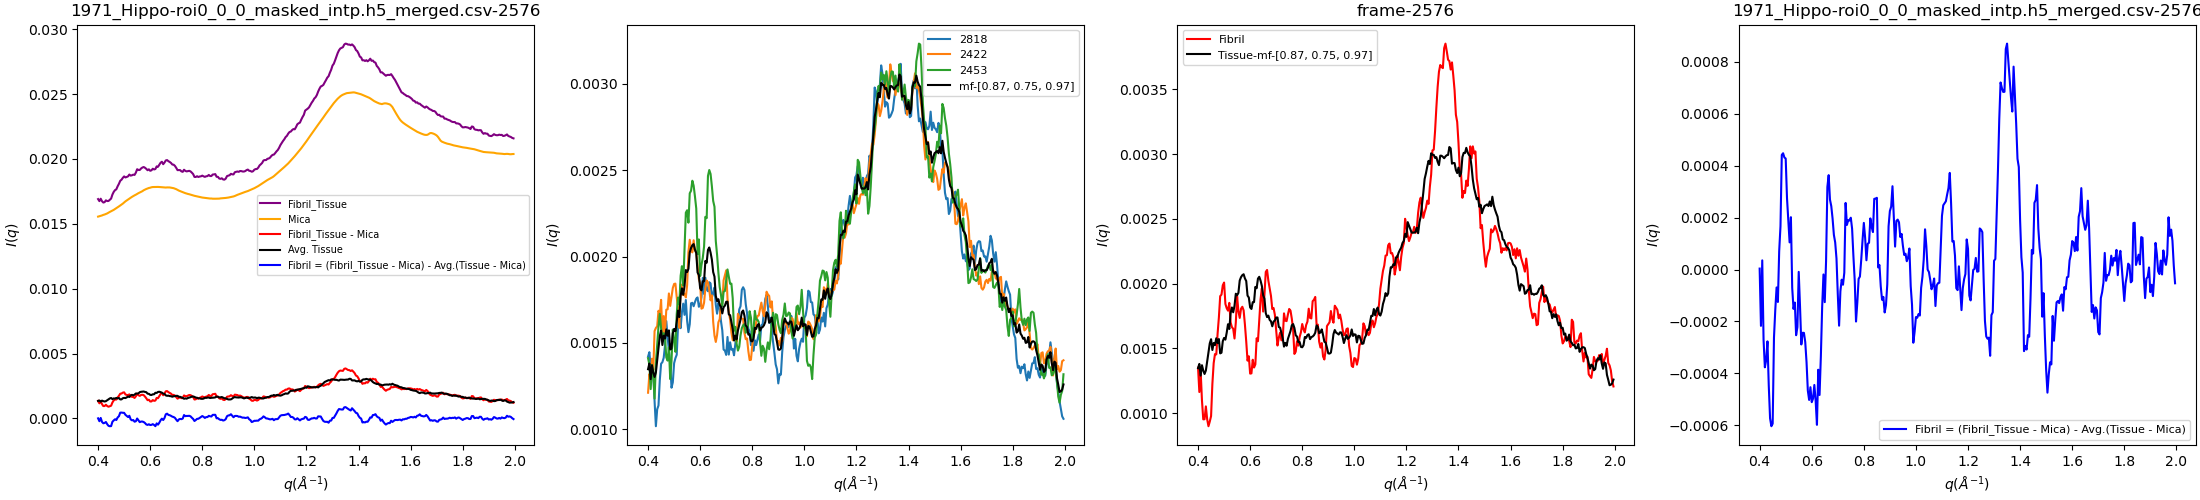

In [25]:
### visualize background subtracted using kernel search
%matplotlib widget

plt_lidx, plt_uidx = qgrid_to_indices(qgrid2, 0.4) , qgrid_to_indices(qgrid2, 2.0) 

plt.close('all')

f, axs = plt.subplots(ncols=4, nrows=1, figsize=(22,5), constrained_layout=True)
def plots(df_idx, frame_idx):
    frame_idx_w.max = len(dataset_val.df.iloc[df_idx]['in_frames'])-1
    axs[0].clear()
    q         = qgrid2[plt_lidx:plt_uidx]
    frame     = dataset_val.df.iloc[df_idx]['in_frames'][frame_idx]
    sel_tissue_frames = dataset_val.df.iloc[df_idx]['sel_tissue_frames'][frame_idx]
    file      = dataset_val.df.iloc[df_idx]['File_Loc']
    Iq        = dataset_val.df.iloc[df_idx]['Iq'][frame_idx][plt_lidx:plt_uidx]                # (690,)
    Iq_bkg    = dataset_val.df.iloc[df_idx]['Iq_bkg'][0, plt_lidx:plt_uidx]                    # (690,)
    Iq_BS     = dataset_val.df.iloc[df_idx]['Iq_BS'][frame_idx][plt_lidx:plt_uidx]             # (690,)
    sel_tissue_mf = dataset_val.df.iloc[df_idx]['sel_tissue_mf'][frame_idx]                    # (3,)
    sel_IqBSTF_avg= dataset_val.df.iloc[df_idx]['sel_IqBSTF_avg'][frame_idx][plt_lidx:plt_uidx]# (690,)
    sel_IqBSTS = dataset_val.df.iloc[df_idx]['sel_IqBSTS'][frame_idx][plt_lidx:plt_uidx]       # (690,)
        
    axs[0].plot(q, Iq, color = 'purple', label='Fibril_Tissue')
    axs[0].plot(q, Iq_bkg , color = 'orange', label='Mica')
    axs[0].plot(q, Iq_BS, color='red', label='Fibril_Tissue - Mica')
    axs[0].plot(q, sel_IqBSTF_avg, color='black', label=f'Avg. Tissue')
    axs[0].plot(q, sel_IqBSTS, color = 'blue', label='Fibril = (Fibril_Tissue - Mica) - Avg.(Tissue - Mica)')
    axs[0].set_title(f'{file.split("/")[-1]}-{frame}')
    axs[0].set_xlabel('$q(\AA^{-1})$')
    axs[0].set_ylabel('$I(q)$')
    axs[0].legend(fontsize=7)
    
    sel_IqBSTF = np.array(dataset_val.df.iloc[df_idx]['sel_IqBSTF'][frame_idx])
    sel_IqBSTF = sel_IqBSTF[:,plt_lidx:plt_uidx]  # dataset_val.df.iloc[df_idx]['sel_tissue_mf'][frame_idx
    axs[1].clear()
    axs[1].plot(q, sel_IqBSTF.T, label=sel_tissue_frames)
    print(f'fibril - {frame}, selected tissue frames - {sel_tissue_frames}')
    axs[1].plot(q, sel_IqBSTF_avg, color='black', label=f'mf-{sel_tissue_mf}')
    axs[1].set_xlabel('$q(\AA^{-1})$')
    axs[1].set_ylabel('$I(q)$')
    axs[1].legend(fontsize=8)
    
    axs[2].clear()
    axs[2].plot(q, Iq_BS, color='red', label='Fibril')
    axs[2].plot(q, sel_IqBSTF_avg, color='black', label=f'Tissue-mf-{sel_tissue_mf}')
    axs[2].set_title(f'frame-{frame}')
    axs[2].set_xlabel('$q(\AA^{-1})$')
    axs[2].set_ylabel('$I(q)$')
    axs[2].legend(fontsize=8)

    axs[3].clear()
    axs[3].plot(q, sel_IqBSTS, color = 'blue', label='Fibril = (Fibril_Tissue - Mica) - Avg.(Tissue - Mica)')
    axs[3].set_title(f'{file.split("/")[-1]}-{frame}')
    axs[3].set_xlabel('$q(\AA^{-1})$')
    axs[3].set_ylabel('$I(q)$')
    axs[3].legend(fontsize=8)


df_idx       = widgets.IntSlider(min=0, max=len(dataset_val.df)-1,value=0)
frame_idx_w  = widgets.IntSlider(min=0, max=len(dataset_val.df)-1,value=0)
# plt.tight_layout()
widgets.interactive(plots, df_idx=df_idx, frame_idx=frame_idx_w )

In [174]:
### load PDB scattering plot
%matplotlib widget

class PDBDataset(object):
    def __init__(self, path, degs_each_pdb):
        self.degs_each_pdb = degs_each_pdb
        df = pd.DataFrame(columns= ['pdb', 'lesion', 'twist', 'length', 'file_loc', 'Iq'])
        for i, (root, dir, files) in enumerate(os.walk(path)):
            # print(i,root, dir, files)
            pass
        idx = 0
        for lesion in next(os.walk(path))[1]:
            print(lesion)
            for pdb in next(os.walk(os.path.join(path, lesion)))[1]:
                csv_dir = os.path.join(path, lesion, pdb, 'CSV')
                if not os.path.isdir(csv_dir):
                    print(f'{csv_dir} is missing')
                else:
                    csv_files = [csv for csv in os.listdir(csv_dir) if csv.endswith('.csv')]
                    csv_files = sorted(csv_files, key = lambda file : int(file.split(' ')[-1].split('.csv')[0].split('L')[1]))# )
        
                    for file in csv_files:
                        file_loc = os.path.join(csv_dir, file)                    
                        
                        df_temp = pd.read_csv(file_loc, delimiter = ',')
                        for deg in degs_each_pdb:
                            df.at[idx, 'lesion']   = lesion
                            df.at[idx, 'pdb']      = pdb
                            df.at[idx, 'file_loc'] = file_loc 
                            df.at[idx, 'length']   = int(file.split(' ')[-1].split('.csv')[0].split('L')[1])
                            df.at[idx, 'twist']    = deg
                            try:
                                df.at[idx, 'Iq']       = df_temp[deg].tolist()
                            except: 
                                print(f'{file_loc} at {deg} not found')
                            idx += 1
        self.q  = df_temp['q'].to_numpy()
        self.df = df

degs_each_pdb     = ['-3', '-2', '-1', '0', '1', '2', '3']
folder_path = "/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Dataset/"


### create object
obj = PDBDataset(folder_path, degs_each_pdb)
obj.df

Abeta
Tau


,pdb,lesion,twist,length,file_loc,Iq
0,2MVX,Abeta,-3,1,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[1588140.0, 1561700.0, 1485250.0, 1366880.0, 1..."
1,2MVX,Abeta,-2,1,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[1588140.0, 1561700.0, 1485250.0, 1366880.0, 1..."
2,2MVX,Abeta,-1,1,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[1588140.0, 1561700.0, 1485250.0, 1366880.0, 1..."
3,2MVX,Abeta,0,1,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[1588140.0, 1561700.0, 1485250.0, 1366880.0, 1..."
4,2MVX,Abeta,1,1,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[1588140.0, 1561700.0, 1485250.0, 1366880.0, 1..."
...,...,...,...,...,...,...
12147,6QJH,Tau,-1,40,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[906358000.0, 805063000.0, 575868000.0, 357261..."
12148,6QJH,Tau,0,40,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[905944000.0, 805594000.0, 578216000.0, 360595..."
12149,6QJH,Tau,1,40,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[904772000.0, 803768000.0, 575857000.0, 359347..."
12150,6QJH,Tau,2,40,/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Da...,"[902807000.0, 799675000.0, 569067000.0, 353757..."


(54, 160)


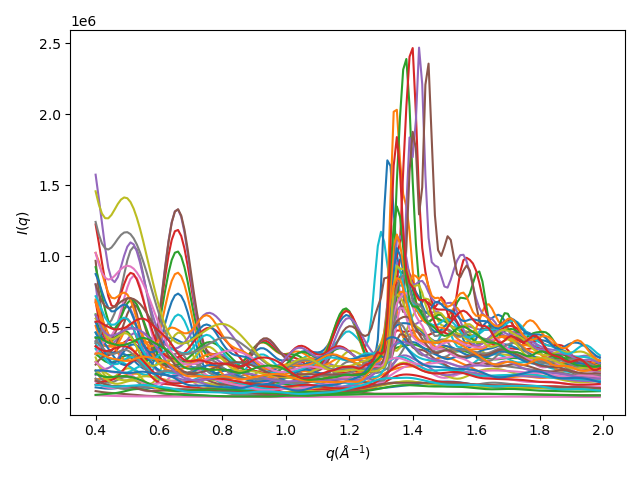

In [293]:
### some random plots

### specs
random_frames = np.arange(320,3000,50)
lidx = np.argmin(qgrid < 0.4)   # qvalue = 0.7,  idx = 190
uidx = np.argmin(qgrid < 2.0)   # qvalue = 1.46, idx = 342

### computation
y = obj.df.Iq.iloc[random_frames]
y = np.vstack(y)
y = y[:,lidx:uidx]
print(y.shape)
plt.close('all')
plt.figure()
plt.plot(qgrid[lidx:uidx], y.T)
plt.xlabel('$q(\AA^{-1})$')
plt.ylabel('$I(q)$')
plt.tight_layout()
plt.show()

In [327]:
### stats about the CRYSOL generated data
from scipy.signal import find_peaks

lidx = np.argmin(qgrid < .5)   # qvalue = 0.7,  idx = 190
uidx = np.argmin(qgrid < 2.0)   # qvalue = 1.46, idx = 342

df_peak = pd.DataFrame(columns=['pdb', 'twist', 'peakQ', 'length'])
X = np.array(obj.df.Iq.tolist())
qvalues = np.array([0. , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.  ])
for i in range(len(X)):
    df_peak.at[i,'pdb']   = obj.df.pdb[i]
    df_peak.at[i,'twist'] = obj.df.twist[i]
    
    peaks,_ = find_peaks(X[i][lidx:uidx], distance=200)
    df_peak.at[i,'peakQ'] = np.float32(qvalues[lidx:uidx][peaks])
    df_peak.at[i,'length'] = 30
print(df_peak['peakQ'].value_counts(), df_peak['peakQ'].astype(np.float32).describe() )

nums = df_peak.iloc[::]['peakQ'].value_counts(bins=5, normalize=False)
nums

peakQ
1.35    2684
1.34    2638
1.36    1227
1.33    1049
1.37     695
        ... 
1.18       1
1.62       1
0.6        1
1.64       1
1.65       1
Name: count, Length: 67, dtype: int64 count    12152.000000
mean         1.320939
std          0.179978
min          0.510000
25%          1.340000
50%          1.350000
75%          1.370000
max          1.680000
Name: peakQ, dtype: float64


(1.212, 1.446]    10854
(1.446, 1.68]       686
(0.508, 0.744]      575
(0.978, 1.212]       37
(0.744, 0.978]        0
Name: count, dtype: int64

In [208]:
### model fitting class
### CSV Files q value must be same for all files
from scipy import stats
import seaborn as sns

class template_matching:
    
    def __init__(self, dataset_val, df_template, nsorts, qgrid, fit_minq=1.25, fit_maxq=1.45, lesion_type='all', window_size=1, save_minq=0.4, same_maxq=2.0):

        self.__qualname__ = f'Templates {lesion_type}'

        if lesion_type == 'all':
            df_template = df_template.copy(deep=True)
            
        else :  # templete == 'Abeta' or templete == 'Tau'
            df_template = df_template.iloc[(df_template['lesion']==lesion_type).values].copy(deep=True)
        
        PDB = np.vstack(df_template['Iq'].iloc[::]) # tau and abeta
        print(f'{lesion_type} Crysol data used for templete mathching of PDB size: {PDB.shape}, DataFrame size: {dataset_val.x.shape}', )

        ### Numpy Experimental data (39 x 690)
        # dataset_val = XrayData(df_val, column_names, BNL_dir, sub_dir, lidx=0, uidx=690, mica_sub=mica_sub, scaling=scaling, tissue_sub=True)

        ### fitting on this q-points
        lidx_ , uidx_ = qgrid_to_indices(qgrid, fit_minq), qgrid_to_indices(qgrid, fit_maxq)
        Iq_model_ = PDB[:,lidx_:uidx_]
        Iq_model_ = np.divide(Iq_model_,Iq_model_.max(axis=1, keepdims=True))

        Iq = dataset_val.x
        ### low pass filtering of data if wanted
        window      = np.ones(window_size)/window_size      
        Iq = np.array([np.convolve(window, Iq[idx], mode='same') for idx in range(Iq.shape[0])  ]) if window_size>1 else Iq   # filter output using convolution

        Iq_intp =  [np.interp(qgrid, qgrid2, Iq[i]) for i in range(len(Iq))]
        Iq_intp = np.vstack(Iq_intp)
        Iq_exp_  = Iq_intp[:, lidx_:uidx_]
        
        Iq_exp_  = np.divide(Iq_exp_, Iq_exp_.max(axis=1,keepdims=True))
        
        ### saving on these q-points
        lidx , uidx = qgrid_to_indices(qgrid, save_minq), qgrid_to_indices(qgrid, same_maxq)
        Iq_model = PDB[:, lidx:uidx]
        Iq_model = np.divide(Iq_model,Iq_model_.max(axis=1, keepdims=True))
        
        Iq_exp = Iq_intp[:, lidx:uidx]
        Iq_exp = np.divide(Iq_exp, Iq_exp_.max(axis=1,keepdims=True))
        
        df = pd.DataFrame([],columns=['file', 'frame', 'pdb','lesion','twist','length','Iq_exp', 'Iq_model','q', 'pdb_idx','metric' ])
        for i in range(len(dataset_val)):
        
            metric = np.round(np.array([calculate_mse(Iq_exp_[i], Iq_model_[idx])  for idx in range(len(PDB)) ]),4)
        
            idx = np.argsort(metric)
            idx = idx[:nsorts]
        
            df.at[i, 'file']  = dataset_val.files[i].split('/')[-1]
            df.at[i, 'frame'] = dataset_val.frames[i]
            df.at[i, 'metric']   = metric[idx].tolist()
            df.at[i, 'pdb']      = df_template['pdb'].iloc[idx].values.tolist()
            df.at[i, 'lesion']   = df_template['lesion'].iloc[idx].values.tolist()
            df.at[i, 'twist']    = df_template['twist'].iloc[idx].values.tolist()
            df.at[i, 'length']   = df_template['length'].iloc[idx].values.tolist()
            df.at[i, 'q']        = qgrid[lidx:uidx]
            df.at[i, 'Iq_exp']   = Iq_exp[i]
            df.at[i, 'Iq_model'] = Iq_model[idx].tolist()
            df.at[i, 'pdb_idx']  = idx.tolist() if len(idx)==1 else idx
        
        self.df = df
        self.df_template = df_template        
    

def calculate_r2(exp, model):
    avg      = np.mean(exp)
    ss_res   = np.sum(np.square(exp-avg))
    ss_total = np.sum(np.square(exp-model))
    return 1 - ss_res/ss_total

def calculate_mse(exp, model):
    return np.sum(np.square(exp-model))


def extract_file_summary_from_df(df_obj, file):
    
    df, df_template = df_obj.df, df_obj.df_template
    df = df[df['file'] == file]
    
    ### find unique pdbs
    df_log = {}
    for idx in range(len(df)):
        for i, pdb_id in enumerate(df.iloc[idx]['pdb']):
            # print(len(pdb_ids))
                # print(pdb_id)
            if pdb_id not in df_log:
                df_log[pdb_id] = {}
                df_log[pdb_id]['data'] = np.empty(shape=(0,2))
            if pdb_id in df_log:
                var = [df.iloc[idx]['length'][i], df.iloc[idx]['twist'][i]]
                # print(var)
                df_log[pdb_id]['data'] = np.vstack((df_log[pdb_id]['data'], var ))
    ### go over each pdb and add labels
    labels = []
    for pdb_id, items in df_log.items():
        items = np.array(items['data'], dtype=np.float32)
        length, twist = items[:,0], items[:,1]
        m = stats.mode(twist)
        lmin, lmax = length.min(), length.max()
        lesion_type = df_template[df_template.pdb==pdb_id]["lesion"].unique().tolist()[0]
        labels = f' {lesion_type} ({len(length)}), twist(mode)={m[0]}({m[1]}), len = [{lmin}, {lmax}]'
        df_log[pdb_id]['label'] = labels
        # print(m[0], m[1], l, pd.DataFrame(twist).describe())
        # stats.describe(length)
        # stats.describe(twist)
        # stats.describe(length)
        # print(pdb_id, length, twist)
    
    ### bar plot
    pdbs   = list(df_log.keys())    
    counts = [len(df_log[k]['data']) for k in df_log]
    labels = [df_log[k]['label'] for k in df_log]
    print(f'--------------- {file} stats STARTS ---------------')
    print(*[f'PDB-{p}-{labels[i]}\n' for i,p in enumerate(pdbs)],sep='\n')

    return df, pdbs, counts, labels

def plot_bar(unique, counts, f, ax, ylabel, labels, title, save_file_loc):
    height = 0.9
    fontsize = 6
    ax.barh(unique, width=counts, height=height)
    ax.bar_label(ax.containers[0], labels = labels, fontsize=fontsize)   # fmt=lambda x: f' {x:0.0f}'
    ax.set_xlabel('counts')
    ax.set_ylabel(ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(enable=True) 
    ax.set_title(title)
    if save_file_loc:
        # ax.figure.savefig(save_file_loc, format='png', dpi=600, transparent=False)

        # Now create a new figure to save only this specific Axes
        fig_single, ax_single = plt.subplots(constrained_layout=True)
        
        # Recreate the barh plot and apply the same settings to the new Axes
        bars = ax_single.barh(unique, width=counts, height=height)
        ax_single.bar_label(bars, labels=labels, fontsize=fontsize)
        ax_single.set_xlabel('counts')
        ax_single.set_ylabel(ylabel)
        ax_single.set_title(title)
        
        # Hide specific spines as in the original plot
        ax_single.spines['top'].set_visible(False)
        ax_single.spines['right'].set_visible(False)
        ax_single.spines['bottom'].set_visible(False)
        ax_single.spines['left'].set_visible(False)
        
        # Match x and y limits if necessary
        ax_single.set_xlim(ax.get_xlim())
        ax_single.set_ylim(ax.get_ylim())

        # Save this new figure
        fig_single.canvas.draw()
        fig_single.savefig(save_file_loc, format='png', dpi=600, transparent=False)
        
        # Optionally close the figure if not needed
        plt.close(fig_single)

### ----------------- specs -----------------
nsorts = 10  # number of templates for each frame
qgrid = np.array([0.00E+00, 1.00E-02, 2.00E-02, 3.00E-02, 4.00E-02, 5.00E-02, 6.00E-02, 7.00E-02, 8.00E-02, 9.00E-02, 1.00E-01, 1.10E-01, 1.20E-01, 1.30E-01, 1.40E-01, 1.50E-01, 1.60E-01, 1.70E-01, 1.80E-01, 1.90E-01, 2.00E-01, 2.10E-01, 2.20E-01, 2.30E-01, 2.40E-01, 2.50E-01, 2.60E-01, 2.70E-01, 2.80E-01, 2.90E-01, 3.00E-01, 3.10E-01, 3.20E-01, 3.30E-01, 3.40E-01, 3.50E-01, 3.60E-01, 3.70E-01, 3.80E-01, 3.90E-01, 4.00E-01, 4.10E-01, 4.20E-01, 4.30E-01, 4.40E-01, 4.50E-01, 4.60E-01, 4.70E-01, 4.80E-01, 4.90E-01, 5.00E-01, 5.10E-01, 5.20E-01, 5.30E-01, 5.40E-01, 5.50E-01, 5.60E-01, 5.70E-01, 5.80E-01, 5.90E-01, 6.00E-01, 6.10E-01, 6.20E-01, 6.30E-01, 6.40E-01, 6.50E-01, 6.60E-01, 6.70E-01, 6.80E-01, 6.90E-01, 7.00E-01, 7.10E-01, 7.20E-01, 7.30E-01, 7.40E-01, 7.50E-01, 7.60E-01, 7.70E-01, 7.80E-01, 7.90E-01, 8.00E-01, 8.10E-01, 8.20E-01, 8.30E-01, 8.40E-01, 8.50E-01, 8.60E-01, 8.70E-01, 8.80E-01, 8.90E-01, 9.00E-01, 9.10E-01, 9.20E-01, 9.30E-01, 9.40E-01, 9.50E-01, 9.60E-01, 9.70E-01, 9.80E-01, 9.90E-01, 1.00E+00, 1.01E+00, 1.02E+00, 1.03E+00, 1.04E+00, 1.05E+00, 1.06E+00, 1.07E+00, 1.08E+00, 1.09E+00, 1.10E+00, 1.11E+00, 1.12E+00, 1.13E+00, 1.14E+00, 1.15E+00, 1.16E+00, 1.17E+00, 1.18E+00, 1.19E+00, 1.20E+00, 1.21E+00, 1.22E+00, 1.23E+00, 1.24E+00, 1.25E+00, 1.26E+00, 1.27E+00, 1.28E+00, 1.29E+00, 1.30E+00, 1.31E+00, 1.32E+00, 1.33E+00, 1.34E+00, 1.35E+00, 1.36E+00, 1.37E+00, 1.38E+00, 1.39E+00, 1.40E+00, 1.41E+00, 1.42E+00, 1.43E+00, 1.44E+00, 1.45E+00, 1.46E+00, 1.47E+00, 1.48E+00, 1.49E+00, 1.50E+00, 1.51E+00, 1.52E+00, 1.53E+00, 1.54E+00, 1.55E+00, 1.56E+00, 1.57E+00, 1.58E+00, 1.59E+00, 1.60E+00, 1.61E+00, 1.62E+00, 1.63E+00, 1.64E+00, 1.65E+00, 1.66E+00, 1.67E+00, 1.68E+00, 1.69E+00, 1.70E+00, 1.71E+00, 1.72E+00, 1.73E+00, 1.74E+00, 1.75E+00, 1.76E+00, 1.77E+00, 1.78E+00, 1.79E+00, 1.80E+00, 1.81E+00, 1.82E+00, 1.83E+00, 1.84E+00, 1.85E+00, 1.86E+00, 1.87E+00, 1.88E+00, 1.89E+00, 1.90E+00, 1.91E+00, 1.92E+00, 1.93E+00, 1.94E+00, 1.95E+00, 1.96E+00, 1.97E+00, 1.98E+00, 1.99E+00, 2.00E+0])
window_size = 1 ## window_size = 1 means use the default 8-point filtered data otherwise use again low_pass filter
fit_minq=1.25
fit_maxq=1.45

### saving on these q-points
save_minq, same_maxq = 0.4, 2.0

### -----------------------------------------
### object creattion
df_all   = template_matching(dataset_val, obj.df, nsorts, qgrid,  fit_minq=fit_minq, fit_maxq=fit_maxq, lesion_type='all',   window_size=window_size, save_minq=save_minq, same_maxq=same_maxq )
df_abeta = template_matching(dataset_val, obj.df, nsorts, qgrid,  fit_minq=fit_minq, fit_maxq=fit_maxq, lesion_type='Abeta', window_size=window_size, save_minq=save_minq, same_maxq=same_maxq )
df_tau   = template_matching(dataset_val, obj.df, nsorts, qgrid,  fit_minq=fit_minq, fit_maxq=fit_maxq, lesion_type='Tau',   window_size=window_size, save_minq=save_minq, same_maxq=same_maxq )
df_all.df

all Crysol data used for templete mathching of PDB size: (12152, 201), DataFrame size: (43, 690)
Abeta Crysol data used for templete mathching of PDB size: (5292, 201), DataFrame size: (43, 690)
Tau Crysol data used for templete mathching of PDB size: (6860, 201), DataFrame size: (43, 690)


,file,frame,pdb,lesion,twist,length,Iq_exp,Iq_model,q,pdb_idx,metric
0,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,768,"[6TI5, 6TI5, 6TI5, 6TI5, 6TI5, 6TI5, 6TI5, 6TI...","[Abeta, Abeta, Abeta, Abeta, Abeta, Abeta, Abe...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[37, 38, 36, 39, 35, 40, 34, 41, 42, 33]","[0.0004000000000000069, 0.0005489999999999823,...","[[806178.0, 790241.0, 745550.0, 675968.0, 5925...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[3967, 3974, 3960, 3981, 3953, 3988, 3946, 399...","[0.1406, 0.1416, 0.1422, 0.1448, 0.1467, 0.149..."
1,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,816,"[6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[92, 90, 94, 93, 88, 95, 91, 89, 96, 97]","[0.00019266666666666493, -3.6666666666645473e-...","[[3198460.0, 3149080.0, 2920470.0, 2698020.0, ...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[5931, 5917, 5945, 5938, 5903, 5952, 5924, 591...","[0.8025, 0.8027, 0.8027, 0.8034, 0.8034, 0.803..."
2,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,818,"[5O3T, 5O3T, 5O3T, 5O3T, 5O3T, 5O3T, 5O3T, 5O3...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[20, 19, 21, 22, 18, 23, 24, 17, 25, 23]","[-0.0002536666666666437, -0.000277000000000016...","[[595663.0, 615022.0, 599235.0, 565401.0, 5248...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[8437, 8430, 8444, 8451, 8423, 8458, 8465, 841...","[0.4207, 0.4233, 0.4258, 0.4335, 0.4368, 0.446..."
3,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,890,"[6QJQ, 6VHA, 6VHA, 6VHA, 6QJQ, 6VHA, 6VHA, 6QJ...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[40, 34, 33, 35, 39, 32, 36, 38, 37, 31]","[0.0005530000000000006, 0.0005246666666666599,...","[[613496.0, 599487.0, 598089.0, 600054.0, 6005...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[8297, 7275, 7268, 7282, 8290, 7261, 7289, 828...","[0.2374, 0.2391, 0.2406, 0.2409, 0.2442, 0.244..."
4,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,891,"[6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2]","[100, 99, 98, 97, 96, 95, 94, 93, 92, 91]","[0.00018800000000000893, 0.0002583333333333239...","[[3318860.0, 3321070.0, 3086430.0, 2829450.0, ...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[5986, 5979, 5972, 5965, 5958, 5951, 5944, 593...","[0.6969, 0.6975, 0.6993, 0.701, 0.7036, 0.706,..."
5,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,892,"[6TI5, 6VHA, 6VHA, 6VHA, 6TI5, 6VHA, 6VHA, 6VH...","[Abeta, Tau, Tau, Tau, Abeta, Tau, Tau, Tau, A...","[3, 1, 1, 1, 3, 1, 1, -1, 3, -1]","[72, 29, 30, 28, 71, 31, 27, 24, 70, 23]","[-1.9999999999997166e-05, 0.000317666666666656...","[[1603290.0, 1578850.0, 1496500.0, 1364320.0, ...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[4213, 7242, 7249, 7235, 4206, 7256, 7228, 748...","[0.3212, 0.3221, 0.3225, 0.3234, 0.3239, 0.325..."
6,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,865,"[5O3T, 5O3T, 5O3T, 5O3T, 5O3T, 5O3T, 5O3T, 5O3...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[29, 28, 30, 27, 31, 32, 26, 33, 34, 35]","[0.0005396666666666759, 0.000633999999999996, ...","[[886508.0, 900266.0, 864033.0, 814493.0, 7601...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[8500, 8493, 8507, 8486, 8514, 8521, 8479, 852...","[0.1804, 0.1808, 0.1811, 0.1829, 0.1835, 0.186..."
7,1898_EC-roi0_0_0_masked_intp.h5_merged.csv,965,"[6VH7, 6VH7, 6VH7, 6VH7, 6VH7, 6VH7, 6VH7, 6VH...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[75, 74, 76, 73, 77, 72, 78, 71, 79, 80]","[0.0006149999999999994, 0.0006936666666666652,...","[[4237270.0, 4322180.0, 4144880.0, 3790450.0, ...","[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47...","[7846, 7839, 7853, 7832, 7860, 7825, 7867, 781...","[0.4832, 0.4842, 

In [215]:
### copy df_all.df to clipboard 
import pyperclip
pyperclip.copy(df_all.df.iloc[-10:][['file', 'frame', 'pdb', 'lesion', 'twist','length', 'metric']])
display(df_all.df.iloc       [-10:][['file', 'frame', 'pdb', 'lesion', 'twist','length', 'metric']])

,file,frame,pdb,lesion,twist,length,metric
33,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,2390,"[6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJ...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[100, 99, 98, 97, 96, 95, 94, 93, 92, 91]","[0.4998, 0.5052, 0.5096, 0.5149, 0.52, 0.5242,..."
34,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1472,"[6TJX, 6TJX, 6TJX, 6TJX, 6TJX, 6TJX, 6TJX, 6TJ...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[100, 99, 98, 97, 96, 95, 94, 93, 92, 91]","[0.7997, 0.8011, 0.8029, 0.8042, 0.8063, 0.808..."
35,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1473,"[6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI3, 6VI...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[86, 88, 84, 90, 87, 83, 85, 82, 89, 81]","[0.2705, 0.2707, 0.2708, 0.2712, 0.2712, 0.271..."
36,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1474,"[6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJ...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[100, 99, 98, 97, 96, 95, 94, 93, 92, 91]","[0.2399, 0.2416, 0.2433, 0.2447, 0.2467, 0.248..."
37,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1475,"[5O3T, 5O3T, 5O3T, 5O3T, 6VHL, 6VHL, 5O3T, 6VH...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[19, 20, 18, 21, 18, 19, 17, 17, 22, 20]","[0.1553, 0.1586, 0.1589, 0.1669, 0.1697, 0.172..."
38,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1476,"[6VHL, 6VHL, 6VHL, 6VHL, 6VHL, 6VHL, 6VHL, 6VH...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[40, 39, 38, 37, 36, 35, 34, 33, 32, 40]","[0.4439, 0.444, 0.4451, 0.4476, 0.4513, 0.4558..."
39,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1477,"[6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJO, 6TJ...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2]","[100, 99, 98, 97, 96, 95, 94, 93, 92, 91]","[0.7392, 0.7438, 0.75, 0.7556, 0.7619, 0.7683,..."
40,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1499,"[6TJX, 6TJX, 6TJX, 6TJX, 6TJX, 6TJX, 6TJX, 6TJ...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[56, 58, 55, 57, 54, 53, 59, 60, 52, 51]","[0.3693, 0.3698, 0.37, 0.3701, 0.3702, 0.3716,..."
41,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1500,"[5O3O, 5O3O, 5O3O, 5O3T, 5O3T, 5O3O, 5O3T, 6HR...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[-1, -1, -1, 1, 1, -1, 1, -1, 1, 1]","[40, 39, 38, 31, 32, 37, 30, 40, 33, 29]","[0.1807, 0.1831, 0.1865, 0.1888, 0.1899, 0.19,..."
42,1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv,1501,"[6VHL, 6VHL, 5O3T, 6VHL, 5O3T, 5O3T, 6VHL, 5O3...","[Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, Tau, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[18, 19, 18, 17, 19, 17, 20, 20, 21, 16]","[0.4946, 0.4985, 0.4991, 0.5025, 0.5055, 0.507..."


--------------- 1898_EC-roi0_0_0_masked_intp.h5_merged.csv stats STARTS ---------------
PDB-6TI5- Abeta (13), twist(mode)=2.0(10), len = [33.0, 72.0]

PDB-6VI3- Tau (53), twist(mode)=-1.0(43), len = [23.0, 100.0]

PDB-5O3T- Tau (17), twist(mode)=-1.0(17), len = [17.0, 33.0]

PDB-6QJQ- Tau (3), twist(mode)=-1.0(3), len = [38.0, 40.0]

PDB-6VHA- Tau (14), twist(mode)=-1.0(9), len = [27.0, 40.0]

PDB-6VH7- Tau (15), twist(mode)=3.0(10), len = [23.0, 80.0]

PDB-6SHS- Abeta (5), twist(mode)=1.0(5), len = [26.0, 30.0]

---------------------- stats for ROI - 1898_EC-roi0_0_0_masked_intp.h5_merged.csv ---------------------- Templates all ----------------------

 ----- pdb-summary -----            0
count    120
unique     7
top     6VI3
freq      53

 ----- twist-summary -----           0
count   120
unique    5
top      -1
freq     74 
     counts
-2      10
-1      74
 1      13
 2      10
 3      13

 ----- length-summary -----                 0
count  120.000000
mean    62.191667
std     3

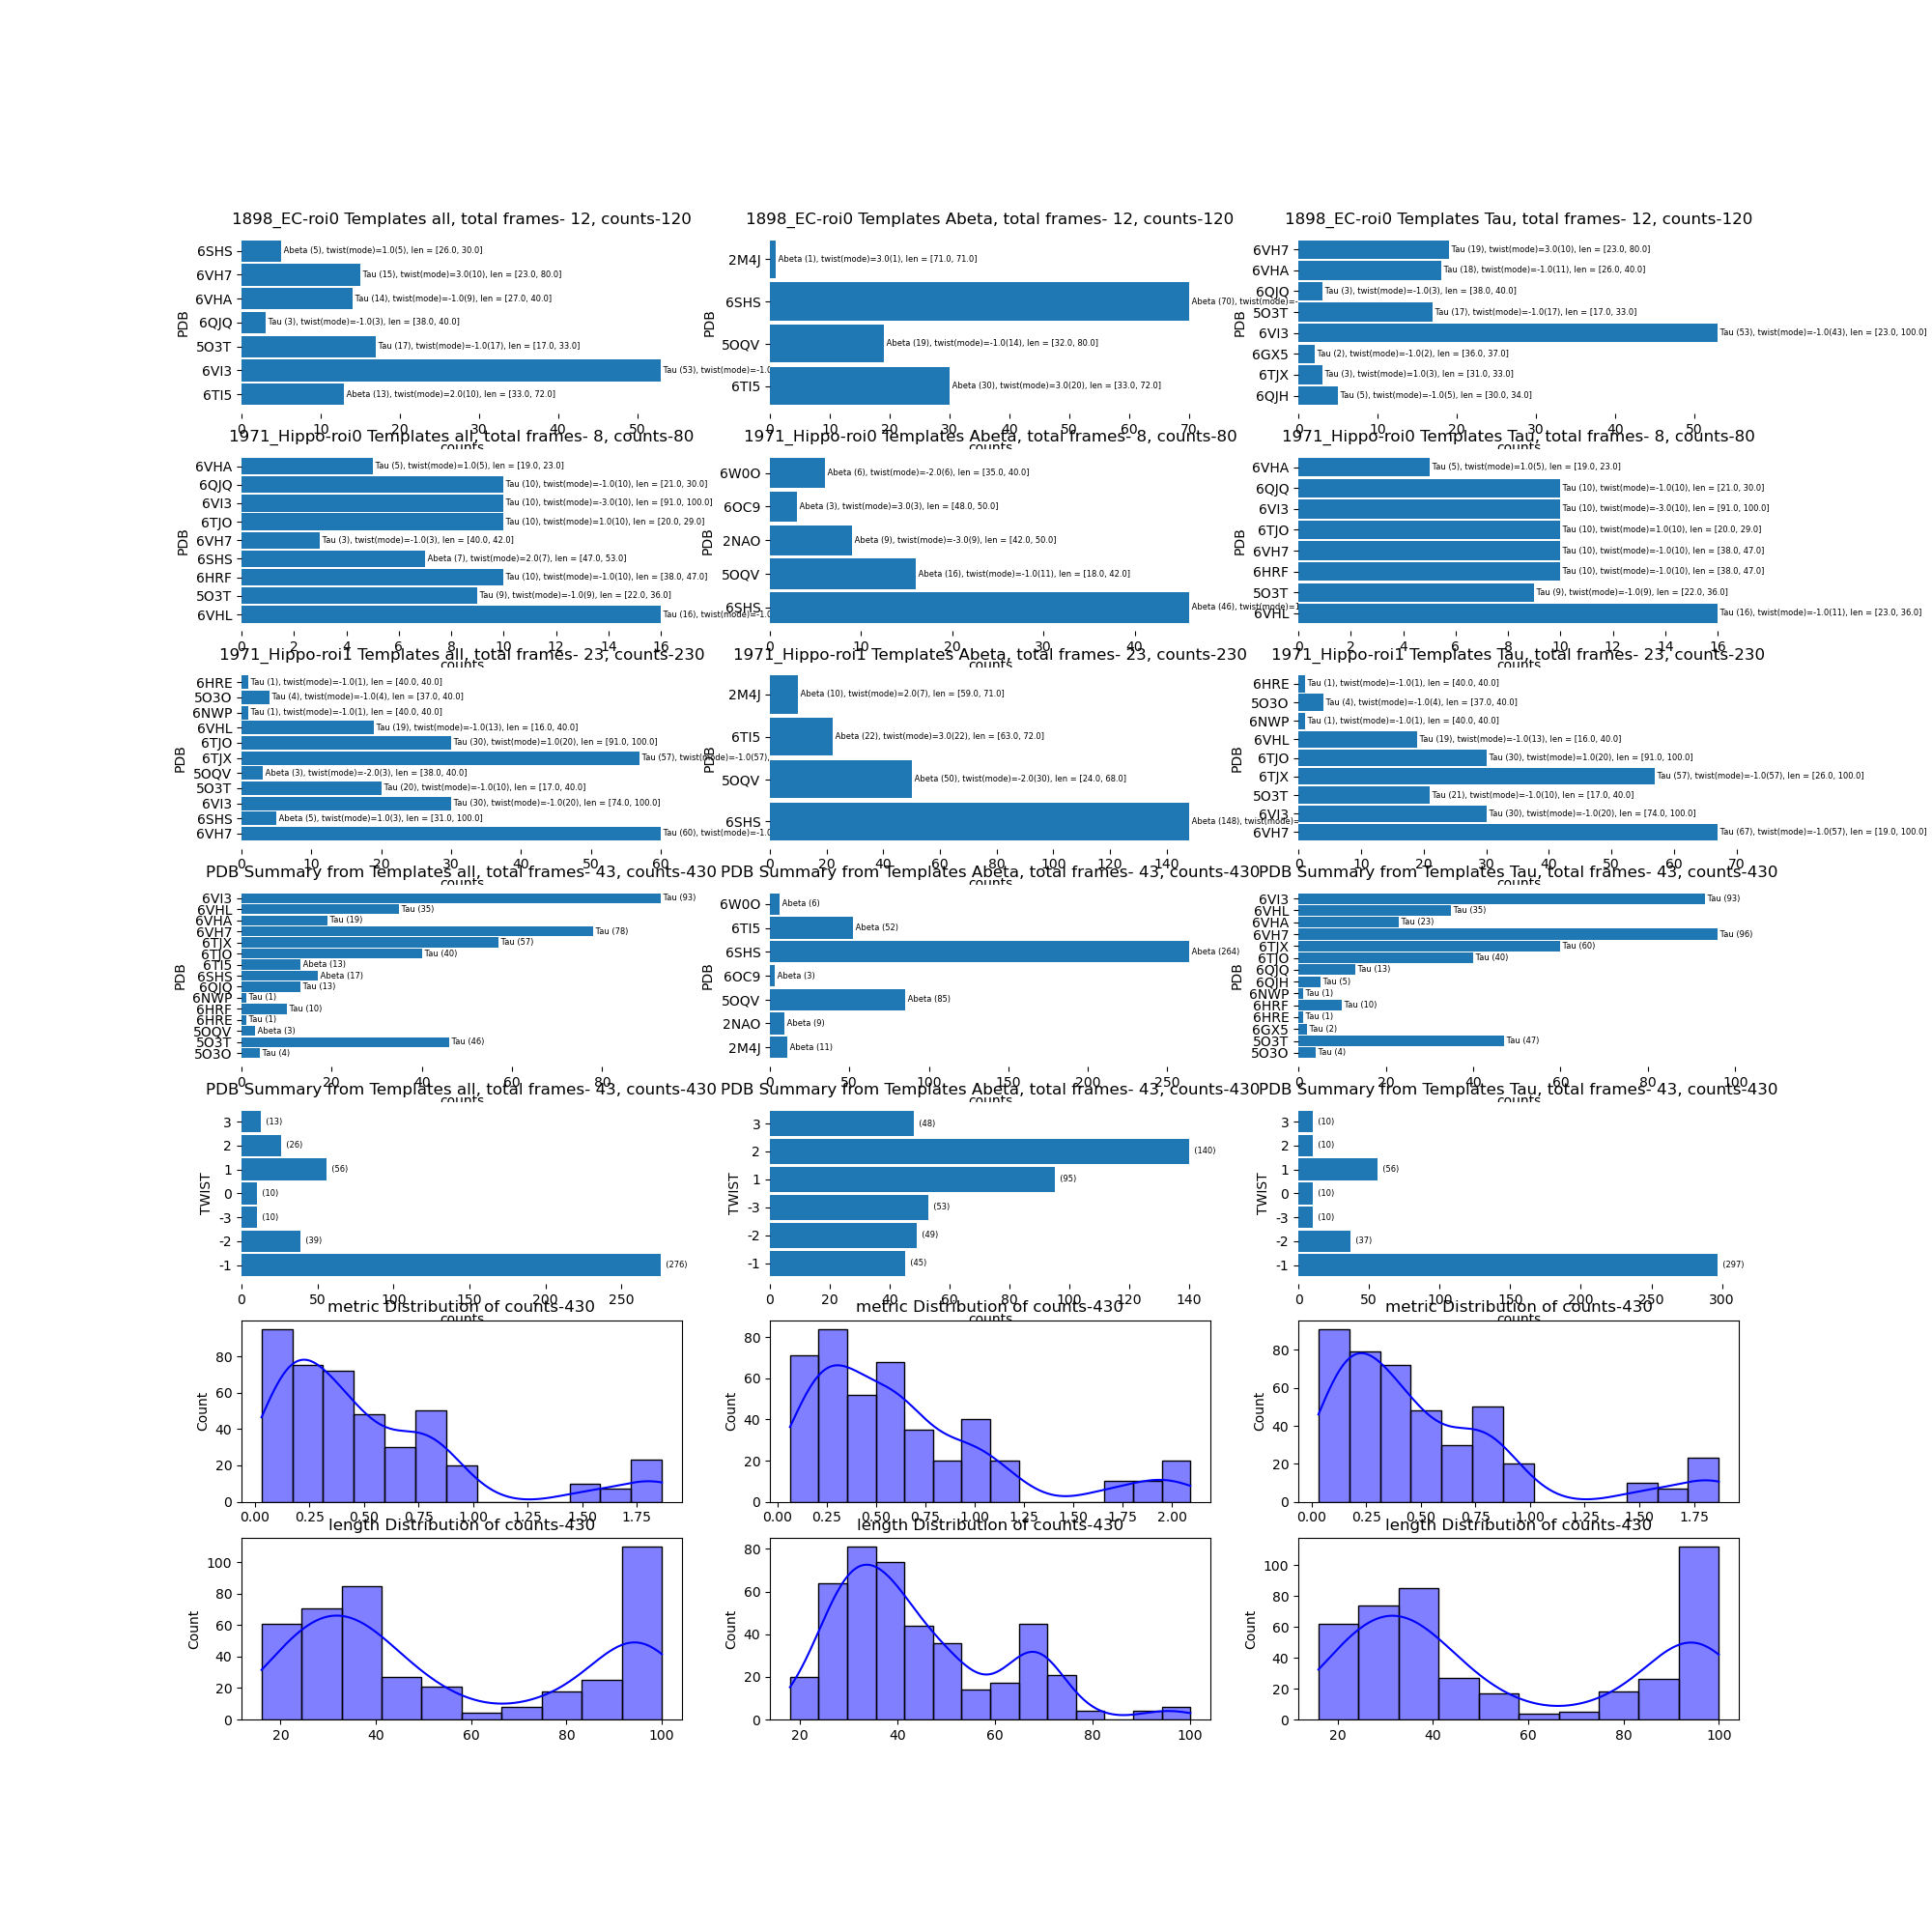

In [209]:
### Fitting model

### ----------------- specs ----------
summary_list = ['pdb','twist', 'metric', 'length']
### ----------------------------------


### get statistics of the df_in matching with df_all, df_abeta, and df_tau
df_objs   = [df_all, df_abeta, df_tau]
files = df_all.df.file.unique()

plt.close('all')
f, axs = plt.subplots(nrows=len(files)+len(summary_list), ncols=len(df_objs), constrained_layout=False, figsize=(20,20))
### plot by files
for ax_i, file in enumerate(files):
    for j, df_obj in enumerate(df_objs):
        
        df, unique, counts, labels = extract_file_summary_from_df(df_obj, file)

        title         = f'{file.split("_0_0")[0]} {df_obj.__qualname__}, total frames- {int(sum(counts)/nsorts)}, counts-{sum(counts)}'
        save_file_loc = f"/Users/bashit.a/Downloads/{file}-{df_obj.__qualname__}.png"
        ylabel = 'PDB'
        plot_bar(unique, counts, f, axs[ax_i,j], ylabel,labels, title, save_file_loc)

        ### stats for each ROI
        print(f'---------------------- stats for ROI - {file} ---------------------- {df_obj.__qualname__} ----------------------')
        pdb_list = [j for i in df['pdb'].values for j in i]
        print('\n', '----- pdb-summary -----', pd.DataFrame(pdb_list).describe())
        twist_list = [j for i in df['twist'].values for j in i]
        unique_twist, counts_twist = np.unique(np.array(twist_list, dtype= int), return_counts=True)
        print('\n', '----- twist-summary -----', pd.DataFrame(twist_list).describe(), '\n', pd.DataFrame(counts_twist, index=unique_twist, columns=['counts'] ))
        length_list = [j for i in df['length'].values for j in i]
        print('\n','----- length-summary -----', pd.DataFrame(length_list).describe())
        metric_list = [j for i in df['metric'].values for j in i]
        print('\n','----- metric-summary -----', pd.DataFrame(metric_list).describe())

### grand total plots
for j, df_obj in enumerate(df_objs):    
    print(f'------------------------{df_obj.__qualname__}----------------- {df_obj.df_template.shape[0]} -----------------------------------------------')
    for nrow_idx, criteria in enumerate(summary_list):
        ax = axs[len(files)+nrow_idx,j] if axs.ndim>1 else axs[j]

        criteria_list = []
        for i in range(len(df_obj.df)):
            criteria_list = criteria_list + df_obj.df[criteria][i][:]

        if criteria == 'metric' or criteria == 'length' :
            sns.histplot(criteria_list,bins='auto',kde=True, color='blue',ax=ax)
            ax.set_title(f'{criteria} Distribution of counts-{len(criteria_list)}')

        elif criteria == 'pdb' or criteria == 'twist':
            unique, counts = np.unique(criteria_list, return_counts=True)
            labels = [f' {df_obj.df_template[df_obj.df_template[criteria]==pdb_id]["lesion"].unique().tolist()[0] if criteria=="pdb" else ""} ({counts[i]})' for i,pdb_id in enumerate(unique)]
            print(f'---- {criteria}-plot-summary ----')
            print(*[f'{criteria}-{p}-{labels[i]}\n' for i,p in enumerate(unique)],sep='\n')
            ylabel = criteria.upper()
            title, save_file_loc = f'PDB Summary from {df_obj.__qualname__}, total frames- {int(sum(counts)/nsorts)}, counts-{len(criteria_list)}', f"/Users/bashit.a/Downloads/pdbs-summary-{df_obj.__qualname__}-{criteria}.png"
            plot_bar(unique, counts, f, ax , ylabel,labels, title, save_file_loc)
        
        ### stats
        print('\n', f'----- {criteria}-summary -----', pd.DataFrame(criteria_list).describe())

# f.suptitle(title)
plt.show()    
plt.tight_layout()
plt.savefig(save_file_loc, format='png', dpi=600, transparent=False)

In [216]:
### output results
%matplotlib widget
from ipywidgets import widgets, fixed


### get objects and variables from previous cells
df_objs   = [df_abeta, df_tau]  # [df_all, df_abeta, df_tau]
lidx_ , uidx_ = qgrid_to_indices(qgrid, fit_minq), qgrid_to_indices(qgrid, fit_maxq)
lidx , uidx = qgrid_to_indices(qgrid, save_minq), qgrid_to_indices(qgrid, same_maxq)

slider     = widgets.IntSlider(min=0, max=len(df_all.df)-1,value=0)
button     = widgets.RadioButtons(options=[1,2,3,4,5],value=1, description='fitting(best-1,lowest-5)')

pdb_slider = widgets.IntSlider(min=0, max=len(df_all.df_template)-1,value=0, description='pdb_idx')
play = widgets.Play( value=0,  min=0, max=len(df_all.df)-1, step=1,  interval=500,    description="Press play",    disabled=False)
widgets.jslink((slider,'value'),(play,'value'))
out = widgets.Output()

plt.close('all')
f, ax = plt.subplots(constrained_layout=True,figsize=(14,8))
df_objs_color = ['orange', 'green', 'blue']

@out.capture(clear_output=True)
def plot_Iq_values(idx, pdb_idx, priority):
    ax.clear()
    
    ### plotting exp and pdb file
    ax.plot(df_all.df.iloc[idx]['q'], df_all.df.iloc[idx]['Iq_exp'] , color='blue',label=f'Exp frame - {df_all.df.iloc[idx]["frame"]}')
    scale = df_all.df.iloc[idx]['Iq_exp'][lidx_-lidx : uidx_-lidx].max()
    
    ### plot for df_all
    for i, df_obj in enumerate(df_objs):
        pdb_idx = pdb_idx if 'all' in df_obj.__qualname__ else df_obj.df.iloc[idx]['pdb_idx'][priority-1]   # slider will abeta and tau template matching requrires new pdb_idx
        Iq_data = np.array(df_obj.df_template.iloc[pdb_idx]['Iq'][lidx:uidx])
        Iq_data = np.divide(Iq_data,Iq_data.max(axis=0, keepdims=True))
        label = f'{df_obj.__qualname__} - {[items[priority-1] for (i, items) in enumerate(df_obj.df.iloc[idx][["lesion", "pdb","twist","length","metric"]])]}'
        ax.plot(df_obj.df.iloc[idx]['q'], scale*Iq_data,label=f'{label}', color=df_objs_color[i])    
        print(df_obj.df.iloc[idx][['pdb','pdb_idx','lesion','twist','length']])


    # ### plot for df_abeta
    # pdb_idx_abeta = df_abeta.df.iloc[idx]['pdb_idx'][priority-1]   
    # Iq_data = np.array(df_abeta.df_template.iloc[pdb_idx_abeta]['Iq'][lidx:uidx])
    # Iq_data = np.divide(Iq_data,Iq_data.max(axis=0, keepdims=True))
    # scale = df_abeta.df.iloc[idx]['Iq_exp'][lidx_-lidx : uidx_-lidx].max()
    # label = f'Abeta templates matched - {[items[priority-1] for (i, items) in enumerate(df_abeta.df.iloc[idx][["lesion", "pdb","twist","length","metric"]])]}'
    # ax.plot(df_abeta.df.iloc[idx]['q'], scale*Iq_data, color='green',label=label)    
    # print(df_abeta.df.iloc[idx][['pdb','pdb_idx','lesion','twist','length']])

    
    ### plot labels and titles
    title = f'{df_all.df.iloc[idx]["file"]}, {df_all.df.iloc[idx]["frame"]}'
    ax.set_xlabel('$q(\AA^{-1})$')
    ax.set_ylabel('$I(q)$')
    ax.set_title(title, fontsize=8)
    # ax.vlines(x=1.5,ymin=-0.2,ymax=1, color='red')
    plt.legend(fontsize=8)
    plt.show()

def on_value_change(idx, priority):
    pdb_idx = df_all.df.iloc[idx]['pdb_idx'][priority-1]   
    plot_Iq_values(idx, pdb_idx, priority)
    pdb_slider.value = pdb_idx
def on_slider_change(change):
    plot_Iq_values(slider.value, change['new'], button.value)

input = widgets.interactive(on_value_change, idx=slider, priority=button)
pdb_slider.observe(on_slider_change, names='value')

display(input, pdb_slider, widgets.VBox([play, out]))

interactive(children=(IntSlider(value=0, description='idx', max=42), RadioButtons(description='fitting(best-1,…

IntSlider(value=3967, description='pdb_idx', max=12151)

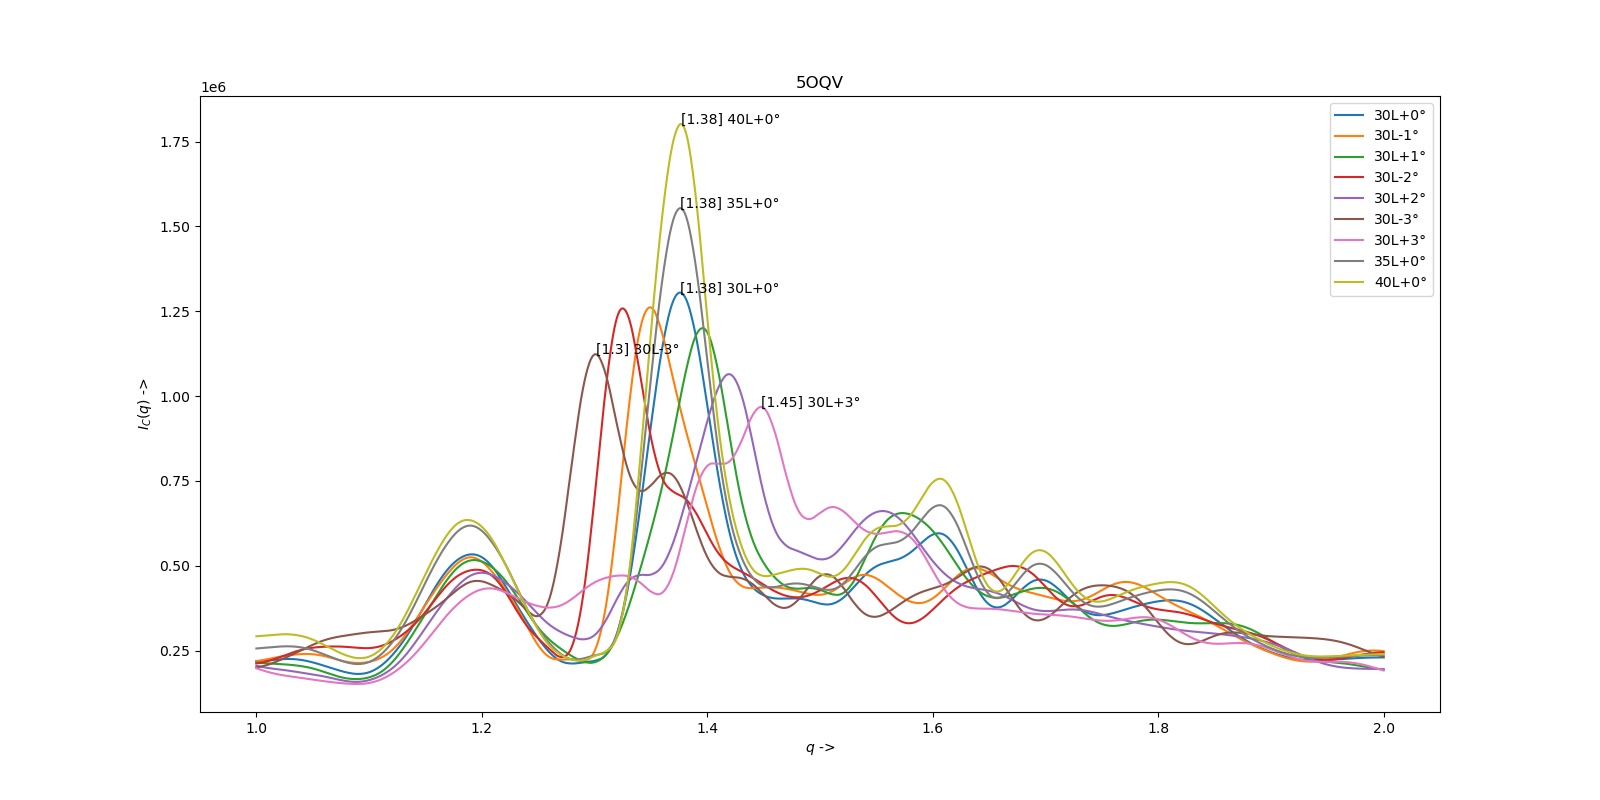

In [11]:
### 5OQV degs and layers
%matplotlib widget
from scipy.signal import find_peaks
from scipy import interpolate


lidx, uidx = 100, 201
pdb_id    =  "5OQV"     # "6VH7" # "5OQV"
base_name = "5oqvLayer" # "6vh7Layer" # "5oqvLayer"
lesion_type = "Abeta"     # "Tau" # "Abeta"

def plot_data_with_peak(xp, fp, ax, label, anno):
    x = np.arange(min(xp), max(xp), 0.0001)
    f = interpolate.interp1d(xp, fp, kind = "quadratic")
    y = f(x)
    ax.plot(x, y, label=label)
    peaks, _ = find_peaks(y, distance=max(y))    
    if anno:
        ax.annotate(str( np.round(x[peaks],2) ) + " " + str(label), (x[peaks], y[peaks]))
        pass
    return

plt.close('all')
f, ax = plt.subplots(figsize=(16,8))
ax.set_xlabel('$q$ ->')
ax.set_ylabel('$I_C(q)$ ->')
ax.set_title(f'{pdb_id}')
os.chdir(f'/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Dataset/{lesion_type}/{pdb_id}/CSV')

df = pd.read_csv(f'Combined {base_name} L30.csv')
x = df['q'].values[lidx : uidx]
plot_data_with_peak(x, df['0'].values[lidx : uidx], ax, label='30L+0\N{DEGREE SIGN}', anno=True)


plot_data_with_peak(x, df['-1'].values[lidx : uidx], ax, label='30L-1\N{DEGREE SIGN}', anno=False)
plot_data_with_peak(x, df['1'].values[lidx : uidx], ax, label='30L+1\N{DEGREE SIGN}', anno=False)

plot_data_with_peak(x, df['-2'].values[lidx : uidx], ax, label='30L-2\N{DEGREE SIGN}', anno=False)
plot_data_with_peak(x, df['2'].values[lidx : uidx], ax, label='30L+2\N{DEGREE SIGN}', anno=False)

plot_data_with_peak(x, df['-3'].values[lidx : uidx], ax, label='30L-3\N{DEGREE SIGN}', anno=True)
plot_data_with_peak(x, df['3'].values[lidx : uidx], ax, label='30L+3\N{DEGREE SIGN}', anno=True)

# plot_data_with_peak(x, df['-4'].values[lidx : uidx], ax, label='30L-4')
# plot_data_with_peak(x, df['4'].values[lidx : uidx], ax, label='30L+4')

# plot_data_with_peak(x, df['-5'].values[lidx : uidx], ax, label='30L-5')
# plot_data_with_peak(x, df['5'].values[lidx : uidx], ax, label='30L+5')


df = pd.read_csv(f'Combined {base_name} L35.csv')
plot_data_with_peak(x, df['0'].values[lidx : uidx], ax, label='35L+0\N{DEGREE SIGN}', anno=True)

df = pd.read_csv(f'Combined {base_name} L40.csv')
plot_data_with_peak(x, df['0'].values[lidx : uidx], ax, label='40L+0\N{DEGREE SIGN}', anno=True)
ax.legend()
plt.show()

### some stats
# df = pd.DataFrame(columns=['pdb', 'twist', 'peakQ', 'length'])
# lidx, uidx = 100, 201
# for i in range(len(X)):
#     df.at[i,'pdb']   = pdb[i]
#     df.at[i,'twist'] = twist[i]

#     peaks,_ = find_peaks(X[i][lidx:uidx], distance=100)
#     df.at[i,'peakQ'] = np.float32(qvalues[lidx:uidx][peaks])
#     df.at[i,'length'] = 30
# print(df['peakQ'].value_counts(), df['peakQ'].astype(np.float32).describe() )

# nums = df.iloc[::]['peakQ'].value_counts(bins=4, normalize=False)
# nums

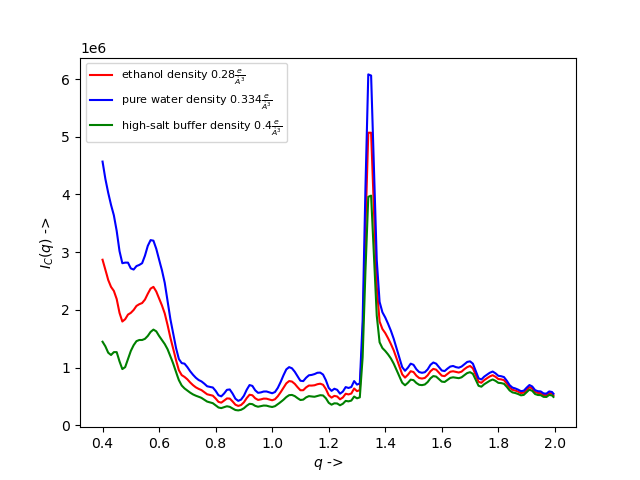

In [26]:
### water density variation testing
import pandas as pd
import pylab as plt
file = "/Users/bashit.a/Documents/Alzheimer/PDB/PDB-Dataset/water-density/water-density-var-6vh7Layer-L40D0.csv"
lidx = np.argmin(qgrid2 < 0.4)   # qvalue = 0.7,  idx = 190
uidx = np.argmin(qgrid2 < 2.0)   # qvalue = 1.46, idx = 342
densities = ['0.28', '0.334', '0.4']

### computation
df = pd.read_csv(file, sep=',')
Iq = {}
Iq['ethanol']  = np.interp(qgrid2, df['q'], df['0.28'])
Iq['water']    = np.interp(qgrid2, df['q'], df['0.334'])
Iq['salt']     = np.interp(qgrid2, df['q'], df['0.4'])

### plots
plt.figure()
plt.plot(qgrid2[lidx:uidx], Iq['water'][lidx:uidx], color='red', label='ethanol density ' + densities[0] + r'$\frac{e}{\mathring{A}^3}$')

plt.plot(qgrid2[lidx:uidx], Iq['ethanol'][lidx:uidx], color='blue', label='pure water density ' + densities[1] + r'$\frac{e}{\mathring{A}^3}$')
plt.plot(qgrid2[lidx:uidx], Iq['salt'][lidx:uidx], color='green', label='high-salt buffer density ' + densities[2] + r'$\frac{e}{\mathring{A}^3}$')
plt.xlabel('$q$ ->')
plt.ylabel('$I_C(q)$ ->')
plt.legend(fontsize=8)
plt.show()